In [ ]:
import numpy as np
import pandas as pd

import utils
from sklearn.metrics.pairwise import paired_distances
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 

import torch



In [ ]:
subjs = utils.ExpInfo.getSubjIDs()
task = utils.ExpInfo.taskName[2]


In [ ]:
task = utils.ExpInfo.taskName[2]
df_beh = [utils.LoadData.behaviorData(x, task) for x in subjs]
df_beh = pd.concat(df_beh)

In [ ]:
df_beh.head()

In [ ]:
df_beh_ = df_beh.query('`actual control`==1')
df_beh_ = df_beh_[['participant', 'number of reaching']]
df_beh_ = df_beh_.groupby(['participant']).mean().reset_index()
df_beh_ = df_beh_.sort_values(by='number of reaching', ascending=False)
topSubj = df_beh_['participant'][0]
topSubj

In [ ]:
model = utils.Model.load(topSubj, 'one_dot')
model = model.double().cuda()


In [ ]:
wSize = 60
x, x_disp = utils.LoadData.mouseMovement_array(topSubj, task)
x = [utils.DataProcessing.rollingWindow(d, wSize) for d in x]

In [77]:
subj = topSubj
df_beh = utils.LoadData.behaviorData(subj, task)
trials = np.where(df_beh['actual control'] == 1)[0]
x_noNoise = [x[i] for i in trials]


In [78]:
def forward(X, model):
    h = []
    for x_ in X:
        x_ = torch.from_numpy(x_).double().cuda()
        y = model.forward(x_)
        h.append(model.model.x_hidden.detach().cpu().numpy())
    return h
h_top = forward(x_noNoise, model)

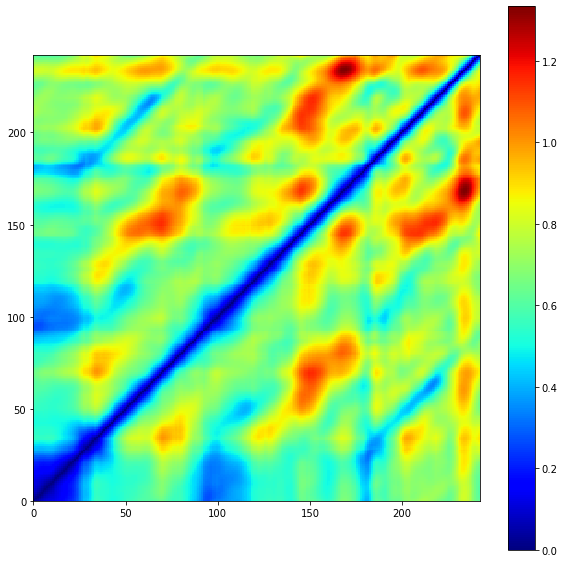

In [79]:
dist_measure = 'euclidean'
h_ = h_top[-1]
dist = pairwise_distances(h_, metric=dist_measure)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
im = ax.pcolormesh(dist, cmap='jet')
plt.colorbar(im)
ax.set_aspect('equal')


In [85]:
def h_dist(subj, x_noNoise):
    model = utils.Model.load(subj, 'one_dot')
    model = model.double().cuda()
    h = forward(x_noNoise, model)
    dist = [pairwise_distances(h_, metric=dist_measure) for h_ in h]
    return dist

dist_mat = [h_dist(subj, x_noNoise) for subj in subjs]

In [98]:
rsa = []
for iTrial in range(len(x_noNoise)):
    d_mat = []
    for iSubj in range(len(subjs)):
        d_mat.append(dist_mat[iSubj][iTrial].flatten())
    d_mat = np.vstack(d_mat)
    rsa.append(np.corrcoef(d_mat))


In [104]:
rsa_mean = np.array(rsa).mean(axis=0)

In [122]:
df_ = pd.DataFrame({'subj': subjs, 'rsa': rsa_mean[df_beh_.index[0], :]})

In [123]:
df_=  df_.sort_values(by='rsa', ascending=False)

,subj,rsa
0,K-Reg-H-10,0.921609
1,K-Reg-H-11,0.889311
2,K-Reg-H-12,0.928270
3,K-Reg-H-13,0.911723
4,K-Reg-H-14,0.877218
5,K-Reg-H-15,0.818146
6,K-Reg-H-16,0.907968
7,K-Reg-H-17,0.919637
8,K-Reg-H-18,0.897960
9,K-Reg-H-19,0.859273


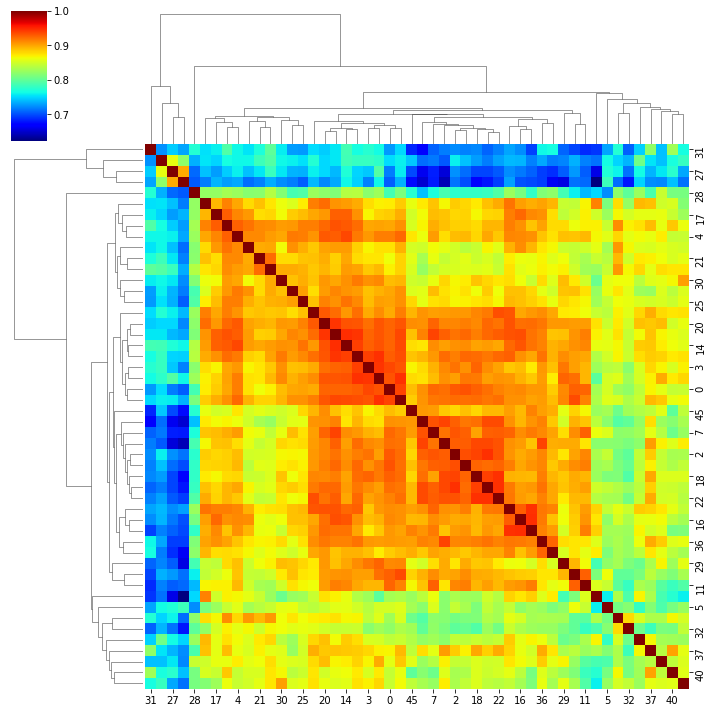

In [106]:
sns.clustermap(rsa_mean, cmap='jet')

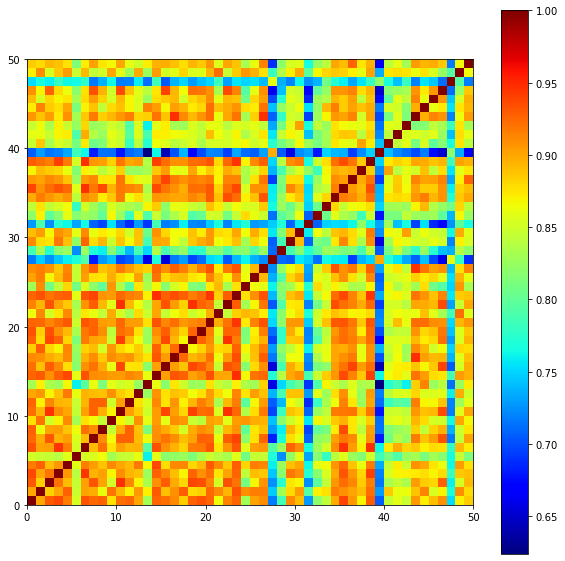

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
im = ax.pcolormesh(rsa_mean, cmap='jet')
plt.colorbar(im)
ax.set_aspect('equal')

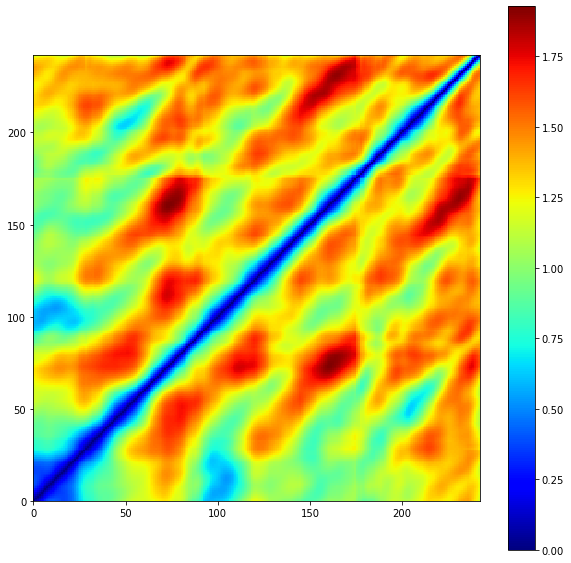

In [81]:
h_ = h[-1]
dist = pairwise_distances(h_, metric=dist_measure)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
im = ax.pcolormesh(dist, cmap='jet')
plt.colorbar(im)
ax.set_aspect('equal')